In [1]:
import os
import tensorflow as tf
import tensorflow_io as tfio


2021-09-07 11:07:25.052648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-07 11:07:25.052674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Example on how to convert a sound to spectrogram

First we need to read the wav file, we use tensorflow-io library to read audio and import it as a tensor.

For more informaton: https://www.tensorflow.org/io/api_docs/python/tfio/audio/AudioIOTensor

In [2]:
audio = tfio.audio.AudioIOTensor('./train/yes397.wav')
print(audio)

<AudioIOTensor: shape=[43813     1], dtype=<dtype: 'int16'>, rate=44100>


2021-09-07 11:07:28.295017: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2021-09-07 11:07:28.366650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-07 11:07:28.366668: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-07 11:07:28.366683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dmillan-lap): /proc/driver/nvidia/version does not exist
2021-09-07 11:07:28.367112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them i

In [3]:
audio_slice = audio.to_tensor()[:,0]

We employ tensorflow-io to convert audio to a spectrogram, we need to convert our audio that is imported in uint16 to float and use the spectrogram function

For more information about spectrogram params: https://www.tensorflow.org/io/api_docs/python/tfio/audio/spectrogram

We can use matplotlib to show the spectrogram result

tf.Tensor(
[[2.2023219e+04 6.5645398e+04 6.1780770e+04 ... 1.9779779e+00
  2.9345806e+00 5.2138672e+00]
 [2.2523436e+04 7.0958203e+04 6.2189855e+04 ... 1.2435195e+00
  1.0377179e+00 1.5058594e+00]
 [8.0663535e+03 7.0665273e+04 5.9559668e+04 ... 7.0138369e+00
  5.7202148e+00 6.2158203e+00]
 ...
 [3.7349266e+04 6.7210617e+04 5.7451516e+04 ... 8.8215370e+00
  1.5750771e+00 2.7617188e+00]
 [5.0753109e+04 4.9437969e+04 3.8724062e+04 ... 4.9608826e+01
  5.2477684e+01 5.1708984e+01]
 [1.3165395e+01 1.3116292e+01 1.2969976e+01 ... 2.9633174e+00
  2.9525640e+00 2.9491491e+00]], shape=(172, 257), dtype=float32)


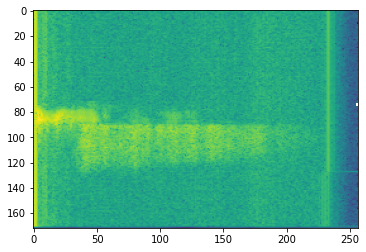

In [4]:
import matplotlib.pyplot as plt

audio_tensor = tf.cast(audio_slice, tf.float32)

spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=512, window=512, stride=256)
print(spectrogram)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())


We require convert the spectrogram result, that is a tensor to an image, to do is, we need to normalize it's values and convert in to a range of 0-255

12.461375
-inf
1.0
-inf


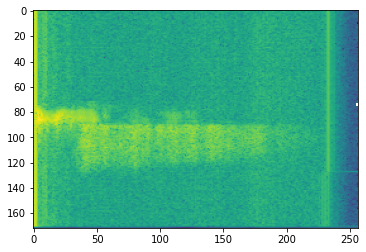

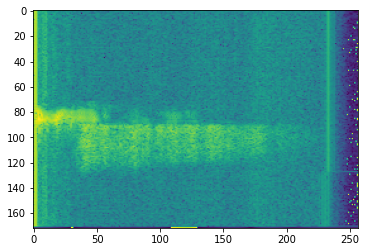

In [5]:
import math
s = tf.math.log(spectrogram)

plt.figure()
plt.imshow(s.numpy())
max = tf.math.reduce_max(s).numpy()
min = tf.math.reduce_min(s).numpy()
if math.isinf(min):
    min=0
print(tf.math.reduce_max(s).numpy())
print(tf.math.reduce_min(s).numpy())
s = (s-min)/(max - min)

print(tf.math.reduce_max(s).numpy())
print(tf.math.reduce_min(s).numpy())

#s = tf.keras.utils.normalize(s)
s = tf.cast(s*255, tf.uint8)
plt.figure()
plt.imshow(s.numpy())


Finally we can use tensorflow using the io module to save the tensor as an image

In [93]:
s = tf.expand_dims(s, -1)
tf.io.write_file("test.jpg", tf.image.encode_jpeg(s, quality=100, format="grayscale"))

# Convert all sounds of train folder in spectrogram images

Loop over all train sounds and convert and normalize 

In [7]:
for i in os.listdir("train"):
    #print(i)
    audio = tfio.audio.AudioIOTensor(os.path.join('./train/',i))
    audio_slice = audio.to_tensor()[:,0]
    audio_tensor = tf.cast(audio_slice, tf.float32)
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=512, window=512, stride=256)
    
    s = tf.math.log(spectrogram)
    max = tf.math.reduce_max(s).numpy()
    min = tf.math.reduce_min(s).numpy()
    if math.isinf(min):
        min=0
    s = (s-min)/(max - min)
    s = tf.cast(s*255, tf.uint8)
    
    s = tf.expand_dims(s, -1)
    tf.io.write_file(os.path.join("train_images", i[:-3]+"jpg"), tf.image.encode_jpeg(s, quality=100, format="grayscale"))
    

# Generate dataset.csv from converted jpg images

In [8]:
import pandas as pd
data=[]
for i in range(0,399):
    data.append(["yes", "train_images/yes"+str(i)+".jpg"])
    data.append(["no", "train_images/no"+str(i)+".jpg"])
    
df = pd.DataFrame(data, columns=["labels", "image"])

In [9]:
df

,labels,image
0,yes,train_images/yes0.jpg
1,no,train_images/no0.jpg
2,yes,train_images/yes1.jpg
3,no,train_images/no1.jpg
4,yes,train_images/yes2.jpg
...,...,...
793,no,train_images/no396.jpg
794,yes,train_images/yes397.jpg
795,no,train_images/no397.jpg
796,yes,train_images/yes398.jpg


In [10]:
df.to_csv("dataset.csv", index=False)